<a href="https://colab.research.google.com/github/afvallejo/Training/blob/main/03_pbmc_colab_annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-Cell Transcriptomics with Scanpy: A Google Colab Tutorial
### Description:
This tutorial walks you through the analysis of single-cell RNA sequencing data using Scanpy, specifically focusing on 65k peripheral blood mononuclear cells (PBMCs) as provided in the Parse Biosciences tutorial. You will learn how to load, preprocess, and visualize single-cell data in Python.

## Setup: Install Required Packages
Let's start by setting up our environment in Google Colab. We'll need to install `scanpy`, `matplotlib`, and a few other important packages.

In [1]:
!pip install scanpy
!pip install anndata
!pip install matplotlib
!pip install seaborn
!pip install h5py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.6 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=9a4b683f78850c5f6e1afe99d8481809eff54214e992598a6e2950a222bf650d
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


## Import Libraries
Now that the packages are installed, we need to import them.

In [3]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Load Data
The PBMC dataset can be downloaded directly from the Parse Biosciences website. Here, for educational purposes, we're going to use an example dataset that can be downloaded directly from Scanpy.

In [4]:
# Download and load the PBMC dataset
adata = sc.datasets.pbmc68k_reduced()  # This is a demo PBMC dataset

# Display basic information about the dataset
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Data Preprocessing
In this section, we'll preprocess the dataset, which includes filtering the cells, normalizing the data, and finding highly variable genes.

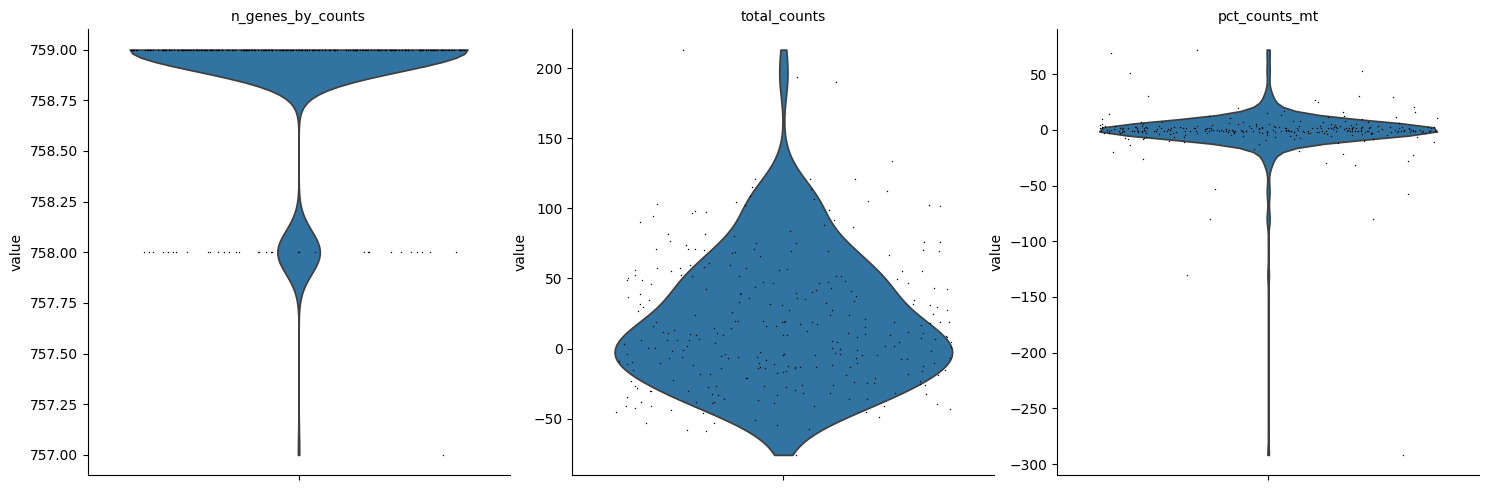

In [5]:
# Filter out low-quality cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Calculate the percentage of mitochondrial genes in each cell
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plot QC metrics to get an overview
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

# Filter cells based on quality control metrics
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

## Normalization & Log Transformation
Next, we'll normalize the data so that each cell has the same total read count. We'll then apply a log transformation to bring the data to a suitable scale for downstream analysis.

In [6]:
# Normalize the data to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:383: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


## Identify Highly Variable Genes
We now need to identify highly variable genes, as these will be informative for downstream analysis like clustering.

In [7]:
# Ensure variable names are unique
adata.var_names_make_unique()

In [8]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot the highly variable genes
sc.pl.highly_variable_genes(adata)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

ValueError: Bin edges must be unique: Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg

## Dimensionality Reduction
We use PCA to reduce the dimensionality of the dataset, which helps us to visualize and better understand our data.

In [ ]:
# Perform PCA for dimensionality reduction
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

# Visualize the PCA results
sc.pl.pca_variance_ratio(adata, log=True)

## Clustering
We can now proceed to cluster the cells based on gene expression patterns using neighborhood graphs and Louvain clustering.

In [ ]:
# Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Perform clustering using the Louvain algorithm
sc.tl.louvain(adata)

# Visualize the clustering using UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=['louvain'])

## Marker Gene Analysis
We want to identify marker genes that define each cluster and use them to annotate cell types.

In [ ]:
# Find marker genes for each cluster
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

## Student Exercise: Annotating Clusters

Now that we have identified clusters and marker genes, let's annotate the clusters.

### Question for Students:
- Based on the marker gene analysis, can you identify which cell types each cluster might represent?
- Look at the top marker genes for each cluster and use external resources (e.g., literature or online databases) to annotate the clusters.

### Problem:
- Write a code snippet to add your annotations to the clusters. Use the `adata.obs['louvain']` column to assign cell type labels.

In [ ]:



Example Solution:

```python
# Example of adding annotations
# Replace the cluster numbers with your identified cell types
cluster_annotations = {
    '0': 'Naive T cells',
    '1': 'Memory T cells',
    '2': 'B cells',
    '3': 'NK cells',
    '4': 'Monocytes'
}

# Annotate the clusters
adata.obs['cell_type'] = adata.obs['louvain'].map(cluster_annotations).astype('category')

# Visualize the annotated clusters
sc.pl.umap(adata, color=['cell_type'])
```